In [1]:
import os
import pickle
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable

import data
from model import *
from trainer import *

## Initialize data

In [2]:
corpus = data.Corpus('./data/ptb')
ntokens = len(corpus.dictionary)

## Hyperparameters

In [3]:
model_test_name = '2_encoder_1_decoder_with_skips_localign'
ckpt_loc = os.path.join('checkpoints', model_test_name+'.pt')

# Training hyperparameters
eval_batch_size = 10
batch_size = 74
seq_len = 18
dropout = 0.1
clip = 2
lr = 0.005
warmup_steps = 10
decay_factor = 0.5
smoothing = 0.05

epochs = 150
early_stopping = 10
log_interval = 150  # Print log every `log_interval` batches

In [4]:
# Model hyperparameters
embed_size = 512
encode_size = 256
h_size = 256
align_size = 256
loc_align_size = 256
loc_align_kernel = 5
decode_size = 256
decode_out_size = 512
n_enc_layers = 2
attn_rnn_layers = 1
n_dec_layers = 1
smooth_align = True
align_location = True
skip_connections = True

## Initialize model, criterion, optimizer, and learning rate scheduler

The learning rate scheduler sets the learning rate factor according to:

$$\text{lr} = d_{\text{model}}^{-0.5}\cdot\min{(\text{epoch}^{-0.5}, \text{epoch}\cdot\text{warmup}^{-1.5})}$$

This corresponds to increasing the learning rate linearly for the first $\text{warmup}$ epochs, then decreasing it proportionally to the inverse square root of the epoch number.

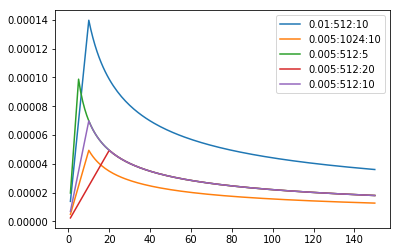

In [5]:
lrate = lambda factor, h_size, warmup: lambda e: factor*(h_size**(-0.5) * min(e**(-decay_factor), e * warmup**(-(decay_factor+1))))
opts = [
    lrate(2*lr, embed_size, warmup_steps), 
    lrate(lr, embed_size*2, warmup_steps),
    lrate(lr, embed_size, warmup_steps//2),
    lrate(lr, embed_size, warmup_steps*2),
    lrate(lr, embed_size, warmup_steps),
]
plt.plot(np.arange(1, epochs+1), [[opt(i) for opt in opts] for i in range(1, epochs+1)])
plt.legend([
    "%.4g:%d:%d" % (2*lr, embed_size, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size*2, warmup_steps),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps//2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps*2),
    "%.4g:%d:%d" % (lr, embed_size, warmup_steps),
])

In [6]:
model = RNNModel(
    src_vocab = ntokens, tgt_vocab = ntokens, embed_size = embed_size,
    encode_size = encode_size, h_size = h_size, align_size = align_size,
    decode_size = decode_size, decode_out_size = decode_out_size,
    n_enc_layers = n_enc_layers, attn_rnn_layers = attn_rnn_layers,
    n_dec_layers = n_dec_layers, align_location = align_location,
    loc_align_size = loc_align_size, loc_align_kernel = loc_align_kernel,
    smooth_align = smooth_align, skip_connections = skip_connections,
    dropout = dropout
)
criterion = LabelSmoothing(ntokens, smoothing = smoothing)
eval_criterion = LabelSmoothing(ntokens, smoothing = 0)
optimizer = optim.Adam(
    model.parameters(), lr = lr, betas = (0.9, 0.98), eps = 1e-9
)
lr_scheduler = get_lr_scheduler(embed_size, warmup_steps, decay_factor, optimizer)
# Reference
nparams = sum([p.numel() for p in model.parameters()])
print('Model parameters: %d' % nparams)

Model parameters: 9458689


## Train
Ready the data

In [7]:
train_data = batchify(corpus.train, batch_size)
val_data = batchify(corpus.valid, eval_batch_size)
test_data = batchify(corpus.test, eval_batch_size)
train_data.size(), val_data.size(), test_data.size()

(torch.Size([12562, 74]), torch.Size([7376, 10]), torch.Size([8243, 10]))

Train and evaluate

In [8]:
train_stats, stat, train_loss, data, targets, states, nstates = train_eval_loop(
    model, train_data, val_data, batch_size, eval_batch_size,
    seq_len, ntokens, criterion, eval_criterion, optimizer,
    lr_scheduler, epochs, warmup_steps, early_stopping,
    clip, log_interval, ckpt_loc
)

Epoch   1/150) lr = 6.988e-06 (warmup)
 b 150/717 >> 2997.4 ms/b | lr: 7.725e-06 | grad norm:  1.26 | inf norm:  0.066 | loss: 8.69 | perp: 5934.52
 b 300/717 >> 2991.2 ms/b | lr: 7.179e-06 | grad norm:  3.73 | inf norm:  0.193 | loss: 7.43 | perp: 1689.39
 b 450/717 >> 2980.2 ms/b | lr: 6.163e-06 | grad norm:  2.03 | inf norm:  0.107 | loss: 6.37 | perp: 585.03
 b 600/717 >> 3004.9 ms/b | lr: 5.938e-06 | grad norm:  2.03 | inf norm: 0.0736 | loss: 6.25 | perp: 520.55
------------------------------------------------------------------------------------------------------------
Elapsed time: 2139.11 sec | train loss, perp: 7.020, 1118.24    | valid loss, perp: 6.545, 695.85   
Grad norm:  1.646 | Grad inf. norm: 0.07911 | Max abs param:  0.4487


Epoch   2/150) lr = 1.398e-05 (warmup)
 b 150/709 >> 2964.5 ms/b | lr: 1.358e-05 | grad norm:  1.32 | inf norm: 0.0333 | loss: 6.26 | perp: 522.91
 b 300/709 >> 2950.1 ms/b | lr: 1.358e-05 | grad norm:  1.57 | inf norm: 0.0689 | loss: 6.19 | perp

------------------------------------------------------------------------------------------------------------
Elapsed time: 2069.99 sec | train loss, perp: 4.829, 125.14    | valid loss, perp: 4.664, 106.02   
Grad norm:  4.787 | Grad inf. norm:  0.6498 | Max abs param:  0.5703


Epoch  11/150) lr = 6.663e-05
 b 150/726 >> 2843.2 ms/b | lr: 6.281e-05 | grad norm:  2.31 | inf norm: 0.0751 | loss: 4.63 | perp: 102.10
 b 300/726 >> 2804.3 ms/b | lr: 7.196e-05 | grad norm: 11.97 | inf norm:   1.37 | loss: 4.48 | perp:  88.67
 b 450/726 >> 2811.7 ms/b | lr: 7.023e-05 | grad norm:  4.57 | inf norm:   0.32 | loss: 4.45 | perp:  85.69
 b 600/726 >> 2860.0 ms/b | lr: 6.663e-05 | grad norm:  5.08 | inf norm:  0.561 | loss: 4.43 | perp:  84.11
------------------------------------------------------------------------------------------------------------
Elapsed time: 2057.97 sec | train loss, perp: 4.488,  88.99    | valid loss, perp: 4.421,  83.14   
Grad norm:  2.612 | Grad inf. norm: 0.08696 | Max

 b 450/715 >> 2799.8 ms/b | lr: 4.941e-05 | grad norm:  8.12 | inf norm:   1.02 | loss: 3.27 | perp:  26.30
 b 600/715 >> 2776.1 ms/b | lr: 4.941e-05 | grad norm:  2.91 | inf norm: 0.0656 | loss: 3.23 | perp:  25.34
------------------------------------------------------------------------------------------------------------
Elapsed time: 1989.78 sec | train loss, perp: 3.301,  27.14    | valid loss, perp: 2.969,  19.47   
Grad norm:  7.253 | Grad inf. norm:  0.4595 | Max abs param:  0.6394


Epoch  21/150) lr = 4.822e-05
 b 150/721 >> 2773.0 ms/b | lr: 5.083e-05 | grad norm:  7.18 | inf norm:   1.22 | loss: 3.33 | perp:  27.85
 b 300/721 >> 2735.8 ms/b | lr: 4.954e-05 | grad norm:  4.27 | inf norm:  0.385 | loss: 3.21 | perp:  24.66
 b 450/721 >> 2794.9 ms/b | lr: 5.451e-05 | grad norm: 17.25 | inf norm:    2.2 | loss: 3.19 | perp:  24.32
 b 600/721 >> 2747.2 ms/b | lr: 5.083e-05 | grad norm: 11.25 | inf norm:   1.07 | loss: 3.20 | perp:  24.44
------------------------------------------

 b 150/718 >> 2789.4 ms/b | lr: 4.145e-05 | grad norm:  7.43 | inf norm:   1.15 | loss: 2.74 | perp:  15.56
 b 300/718 >> 2774.9 ms/b | lr: 4.034e-05 | grad norm:  2.59 | inf norm:  0.294 | loss: 2.71 | perp:  14.96
 b 450/718 >> 2782.4 ms/b | lr: 3.429e-05 | grad norm:  5.46 | inf norm:  0.873 | loss: 2.75 | perp:  15.57
 b 600/718 >> 3145.1 ms/b | lr: 3.921e-05 | grad norm:  8.20 | inf norm:   1.12 | loss: 2.72 | perp:  15.19
------------------------------------------------------------------------------------------------------------
Elapsed time: 2100.89 sec | train loss, perp: 2.733,  15.37    | valid loss, perp: 2.389,  10.91   
Grad norm:  5.531 | Grad inf. norm:  0.4976 | Max abs param:  0.6592


Epoch  31/150) lr = 3.969e-05
 b 150/718 >> 3220.1 ms/b | lr: 3.623e-05 | grad norm: 155.96 | inf norm:   18.2 | loss: 2.64 | perp:  14.04
 b 300/718 >> 3197.3 ms/b | lr: 3.969e-05 | grad norm: 35.48 | inf norm:    4.9 | loss: 2.72 | perp:  15.25
 b 450/718 >> 3325.0 ms/b | lr: 4.078e-05

Epoch  40/150) lr = 3.494e-05
 b 150/722 >> 3031.3 ms/b | lr: 3.395e-05 | grad norm:  8.80 | inf norm:   1.11 | loss: 2.55 | perp:  12.81
 b 300/722 >> 3081.5 ms/b | lr: 3.395e-05 | grad norm:  4.25 | inf norm:  0.312 | loss: 2.40 | perp:  11.03
 b 450/722 >> 3248.7 ms/b | lr: 3.863e-05 | grad norm: 12.30 | inf norm:   1.36 | loss: 2.36 | perp:  10.60
 b 600/722 >> 3134.4 ms/b | lr:  3.59e-05 | grad norm:  3.06 | inf norm:  0.325 | loss: 2.43 | perp:  11.39
------------------------------------------------------------------------------------------------------------
Elapsed time: 2314.26 sec | train loss, perp: 2.433,  11.40    | valid loss, perp: 2.239,   9.38 :(
Grad norm: 19.440 | Grad inf. norm:   2.341 | Max abs param:  0.6699


Epoch  41/150) lr = 3.451e-05
 b 150/721 >> 3671.0 ms/b | lr: 3.254e-05 | grad norm:  2.85 | inf norm:  0.304 | loss: 2.59 | perp:  13.32
 b 300/721 >> 3449.2 ms/b | lr: 3.546e-05 | grad norm:  4.56 | inf norm:  0.141 | loss: 2.42 | perp:  11.25
 b 450/721 >

 b 150/712 >> 3485.1 ms/b | lr: 3.294e-05 | grad norm:  6.85 | inf norm:   0.27 | loss: 2.19 | perp:   8.98
 b 300/712 >> 3482.8 ms/b | lr: 3.037e-05 | grad norm:  2.61 | inf norm: 0.0861 | loss: 2.25 | perp:   9.49
 b 450/712 >> 3785.1 ms/b | lr: 3.211e-05 | grad norm: 20.59 | inf norm:   2.49 | loss: 2.30 | perp:  10.01
 b 600/712 >> 3809.9 ms/b | lr: 2.853e-05 | grad norm: 21.18 | inf norm:  0.799 | loss: 2.37 | perp:  10.65
------------------------------------------------------------------------------------------------------------
Elapsed time: 2618.37 sec | train loss, perp: 2.263,   9.62 :( | valid loss, perp: 1.885,   6.59   
Grad norm: 30.669 | Grad inf. norm:   4.482 | Max abs param:  0.6777


Epoch  51/150) lr = 3.094e-05
 b 150/723 >> 3837.2 ms/b | lr: 3.262e-05 | grad norm:  2.65 | inf norm:  0.054 | loss: 2.24 | perp:   9.37
 b 300/723 >> 4297.9 ms/b | lr: 2.526e-05 | grad norm: 10.57 | inf norm:    2.2 | loss: 2.05 | perp:   7.76
 b 450/723 >> 4179.8 ms/b | lr: 3.342e-05 

Epoch  60/150) lr = 2.853e-05
 b 150/722 >> 4163.0 ms/b | lr: 2.772e-05 | grad norm:  2.36 | inf norm: 0.0581 | loss: 2.00 | perp:   7.40
 b 300/722 >> 4027.4 ms/b | lr: 2.424e-05 | grad norm:  3.27 | inf norm:  0.337 | loss: 2.04 | perp:   7.73
 b 450/722 >> 4052.1 ms/b | lr: 2.424e-05 | grad norm:  5.73 | inf norm:   1.01 | loss: 1.93 | perp:   6.91
 b 600/722 >> 4154.8 ms/b | lr: 3.225e-05 | grad norm: 348.61 | inf norm:   52.2 | loss: 1.98 | perp:   7.22
------------------------------------------------------------------------------------------------------------
Elapsed time: 2947.62 sec | train loss, perp: 1.997,   7.36    | valid loss, perp: 1.717,   5.57   
Grad norm: 25.716 | Grad inf. norm:   3.609 | Max abs param:  0.6839


Epoch  61/150) lr = 2.829e-05
 b 150/715 >> 3751.8 ms/b | lr:  2.75e-05 | grad norm:  2.97 | inf norm:  0.306 | loss: 2.01 | perp:   7.44
 b 300/715 >> 4024.4 ms/b | lr: 2.829e-05 | grad norm:  3.19 | inf norm: 0.0837 | loss: 1.94 | perp:   6.97
 b 450/715 

Epoch  70/150) lr = 2.641e-05
 b 150/718 >> 3167.0 ms/b | lr: 2.784e-05 | grad norm:  5.83 | inf norm:  0.918 | loss: 1.86 | perp:   6.41
 b 300/718 >> 3247.4 ms/b | lr: 2.784e-05 | grad norm: 10.96 | inf norm:   1.08 | loss: 1.85 | perp:   6.39
 b 450/718 >> 3181.5 ms/b | lr: 2.784e-05 | grad norm: 22.86 | inf norm:   1.73 | loss: 2.09 | perp:   8.11
 b 600/718 >> 3113.7 ms/b | lr:  2.49e-05 | grad norm:  2.35 | inf norm:  0.064 | loss: 2.03 | perp:   7.59
------------------------------------------------------------------------------------------------------------
Elapsed time: 2285.02 sec | train loss, perp: 1.953,   7.05 :( | valid loss, perp: 1.620,   5.05   
Grad norm: 16.398 | Grad inf. norm:   2.516 | Max abs param:  0.6887


Epoch  71/150) lr = 2.622e-05
 b 150/716 >> 3321.0 ms/b | lr: 2.472e-05 | grad norm:  5.07 | inf norm:  0.536 | loss: 1.86 | perp:   6.44
 b 300/716 >> 3314.4 ms/b | lr: 2.622e-05 | grad norm:  9.58 | inf norm:    1.5 | loss: 1.97 | perp:   7.17
 b 450/716 >

 b 150/713 >> 3514.5 ms/b | lr: 2.401e-05 | grad norm:  2.53 | inf norm:  0.141 | loss: 1.88 | perp:   6.56
 b 300/713 >> 3219.3 ms/b | lr: 2.471e-05 | grad norm:  6.98 | inf norm:  0.488 | loss: 1.80 | perp:   6.08
 b 450/713 >> 3388.5 ms/b | lr: 2.401e-05 | grad norm:  4.66 | inf norm:  0.515 | loss: 1.79 | perp:   5.98
 b 600/713 >> 3348.9 ms/b | lr: 2.329e-05 | grad norm:  2.81 | inf norm:  0.065 | loss: 1.74 | perp:   5.68
------------------------------------------------------------------------------------------------------------
Elapsed time: 2398.00 sec | train loss, perp: 1.799,   6.04    | valid loss, perp: 1.543,   4.68   
Grad norm: 19.798 | Grad inf. norm:   2.625 | Max abs param:  0.6934


Epoch  81/150) lr = 2.455e-05
 b 150/713 >> 3411.2 ms/b | lr: 2.315e-05 | grad norm:  2.32 | inf norm: 0.0903 | loss: 1.76 | perp:   5.80
 b 300/713 >> 3369.2 ms/b | lr: 2.087e-05 | grad norm:  4.56 | inf norm:  0.596 | loss: 1.73 | perp:   5.61
 b 450/713 >> 3274.0 ms/b | lr: 2.588e-05 

Epoch  90/150) lr = 2.329e-05
 b 150/717 >> 3350.0 ms/b | lr: 2.393e-05 | grad norm:  4.47 | inf norm:  0.627 | loss: 1.72 | perp:   5.59
 b 300/717 >> 3317.8 ms/b | lr: 1.979e-05 | grad norm:  3.57 | inf norm:  0.308 | loss: 1.78 | perp:   5.91
 b 450/717 >> 3340.1 ms/b | lr: 2.126e-05 | grad norm:  2.96 | inf norm:  0.205 | loss: 1.72 | perp:   5.58
 b 600/717 >> 3334.0 ms/b | lr: 2.393e-05 | grad norm:  2.61 | inf norm: 0.0629 | loss: 1.70 | perp:   5.48
------------------------------------------------------------------------------------------------------------
Elapsed time: 2387.94 sec | train loss, perp: 1.721,   5.59    | valid loss, perp: 1.481,   4.40   
Grad norm: 16.425 | Grad inf. norm:   1.704 | Max abs param:  0.6974


Epoch  91/150) lr = 2.316e-05
 b 150/712 >> 3295.8 ms/b | lr:  2.38e-05 | grad norm:  9.81 | inf norm:   1.54 | loss: 1.83 | perp:   6.21
 b 300/712 >> 3368.8 ms/b | lr:  2.38e-05 | grad norm:  2.25 | inf norm:  0.051 | loss: 1.73 | perp:   5.63
 b 450/712 >

 b 150/715 >> 3279.0 ms/b | lr:  2.27e-05 | grad norm:  2.61 | inf norm: 0.0565 | loss: 1.71 | perp:   5.51
 b 300/715 >> 3249.5 ms/b | lr: 2.387e-05 | grad norm:  8.06 | inf norm:  0.783 | loss: 1.66 | perp:   5.28
 b 450/715 >> 3057.4 ms/b | lr: 2.147e-05 | grad norm:  2.38 | inf norm:  0.065 | loss: 1.66 | perp:   5.25
 b 600/715 >> 3501.4 ms/b | lr: 2.017e-05 | grad norm:  3.39 | inf norm:  0.375 | loss: 1.90 | perp:   6.68
------------------------------------------------------------------------------------------------------------
Elapsed time: 2336.80 sec | train loss, perp: 1.717,   5.57 :( | valid loss, perp: 1.438,   4.21 :(
Grad norm:  5.667 | Grad inf. norm:  0.5856 | Max abs param:  0.7003


Epoch 101/150) lr = 2.199e-05
 b 150/725 >> 3246.4 ms/b | lr: 2.073e-05 | grad norm:  2.40 | inf norm: 0.0602 | loss: 1.75 | perp:   5.78
 b 300/725 >> 3204.2 ms/b | lr: 1.869e-05 | grad norm:  7.70 | inf norm:   1.15 | loss: 1.78 | perp:   5.91
 b 450/725 >> 3084.9 ms/b | lr: 2.007e-05 

Epoch 110/150) lr = 2.107e-05
 b 150/715 >> 3589.8 ms/b | lr: 2.048e-05 | grad norm:  2.74 | inf norm:  0.229 | loss: 1.66 | perp:   5.25
 b 300/715 >> 3686.6 ms/b | lr: 2.107e-05 | grad norm:  2.46 | inf norm: 0.0996 | loss: 1.72 | perp:   5.60
 b 450/715 >> 3778.6 ms/b | lr: 2.107e-05 | grad norm:  3.02 | inf norm:  0.243 | loss: 1.63 | perp:   5.11
 b 600/715 >> 3953.2 ms/b | lr: 2.276e-05 | grad norm:  2.79 | inf norm: 0.0919 | loss: 1.62 | perp:   5.05
------------------------------------------------------------------------------------------------------------
Elapsed time: 2684.89 sec | train loss, perp: 1.675,   5.34 :( | valid loss, perp: 1.402,   4.06 :(
Grad norm:  2.978 | Grad inf. norm:  0.2534 | Max abs param:  0.7439


Epoch 111/150) lr = 2.097e-05
 b 150/710 >> 3771.6 ms/b | lr: 2.038e-05 | grad norm:  2.75 | inf norm: 0.0928 | loss: 1.60 | perp:   4.93
 b 300/710 >> 3638.4 ms/b | lr: 2.097e-05 | grad norm:  2.22 | inf norm: 0.0786 | loss: 1.58 | perp:   4.86
 b 450/710 >

 b 150/721 >> 3447.4 ms/b | lr: 1.902e-05 | grad norm:  2.59 | inf norm: 0.0677 | loss: 1.58 | perp:   4.88
 b 300/721 >> 3365.6 ms/b | lr:  1.96e-05 | grad norm:  3.98 | inf norm:  0.445 | loss: 1.63 | perp:   5.09
 b 450/721 >> 3312.5 ms/b | lr: 1.714e-05 | grad norm:  6.37 | inf norm:  0.985 | loss: 1.53 | perp:   4.63
 b 600/721 >> 3402.1 ms/b | lr: 1.779e-05 | grad norm:  3.54 | inf norm:  0.199 | loss: 1.62 | perp:   5.07
------------------------------------------------------------------------------------------------------------
Elapsed time: 2429.09 sec | train loss, perp: 1.588,   4.89 :( | valid loss, perp: 1.365,   3.91 :(
Grad norm:  4.571 | Grad inf. norm:  0.1784 | Max abs param:  0.7811


Epoch 121/150) lr = 2.009e-05
 b 150/715 >> 3484.2 ms/b | lr: 1.894e-05 | grad norm:  3.76 | inf norm:  0.305 | loss: 1.58 | perp:   4.83
 b 300/715 >> 3358.6 ms/b | lr: 2.221e-05 | grad norm: 14.30 | inf norm:  0.709 | loss: 1.60 | perp:   4.98
 b 450/715 >> 3368.4 ms/b | lr: 2.009e-05 

 b 150/718 >> 3388.4 ms/b | lr: 2.093e-05 | grad norm:  3.27 | inf norm:  0.144 | loss: 1.60 | perp:   4.94
 b 300/718 >> 3459.3 ms/b | lr: 1.991e-05 | grad norm:  2.86 | inf norm:  0.249 | loss: 1.53 | perp:   4.62
 b 450/718 >> 3435.6 ms/b | lr: 2.093e-05 | grad norm:  6.60 | inf norm:  0.534 | loss: 1.55 | perp:   4.71
 b 600/718 >> 3325.7 ms/b | lr: 2.043e-05 | grad norm:  2.72 | inf norm:  0.106 | loss: 1.60 | perp:   4.97
------------------------------------------------------------------------------------------------------------
Elapsed time: 2438.67 sec | train loss, perp: 1.570,   4.81 :( | valid loss, perp: 1.338,   3.81 :(
Grad norm:  3.031 | Grad inf. norm: 0.09146 | Max abs param:  0.8114


Epoch 131/150) lr = 1.931e-05
 b 150/719 >> 3649.3 ms/b | lr: 1.876e-05 | grad norm:  3.23 | inf norm: 0.0709 | loss: 1.54 | perp:   4.68
 b 300/719 >> 3678.2 ms/b | lr: 1.931e-05 | grad norm:  2.31 | inf norm: 0.0526 | loss: 1.50 | perp:   4.49
 b 450/719 >> 3512.1 ms/b | lr: 1.931e-05 

 b 150/718 >> 3267.8 ms/b | lr: 1.705e-05 | grad norm:  2.99 | inf norm: 0.0836 | loss: 1.53 | perp:   4.60
 b 300/718 >> 3324.3 ms/b | lr: 1.919e-05 | grad norm:  2.55 | inf norm: 0.0659 | loss: 1.50 | perp:   4.47
 b 450/718 >> 3324.7 ms/b | lr: 1.705e-05 | grad norm:  3.30 | inf norm:   0.27 | loss: 1.48 | perp:   4.40
 b 600/718 >> 3393.9 ms/b | lr: 1.868e-05 | grad norm:  2.46 | inf norm: 0.0991 | loss: 1.50 | perp:   4.49
------------------------------------------------------------------------------------------------------------
Elapsed time: 2391.20 sec | train loss, perp: 1.513,   4.54    | valid loss, perp: 1.315,   3.73   
Grad norm:  2.586 | Grad inf. norm: 0.06741 | Max abs param:  0.8345


Epoch 141/150) lr = 1.861e-05
 b 150/718 >> 3364.2 ms/b | lr: 1.581e-05 | grad norm: 23.92 | inf norm:   1.87 | loss: 1.52 | perp:   4.59
 b 300/718 >> 3336.9 ms/b | lr: 1.861e-05 | grad norm:  2.81 | inf norm:  0.193 | loss: 1.54 | perp:   4.68
 b 450/718 >> 3336.5 ms/b | lr: 1.754e-05 

Epoch 150/150) lr = 1.804e-05
 b 150/712 >> 3111.6 ms/b | lr: 1.753e-05 | grad norm:  2.51 | inf norm: 0.0731 | loss: 1.50 | perp:   4.47
 b 300/712 >> 3080.1 ms/b | lr: 1.701e-05 | grad norm:  2.95 | inf norm:  0.185 | loss: 1.52 | perp:   4.59
 b 450/712 >> 3068.0 ms/b | lr: 1.902e-05 | grad norm:  2.75 | inf norm:  0.201 | loss: 1.59 | perp:   4.92
 b 600/712 >> 3113.5 ms/b | lr: 1.701e-05 | grad norm:  2.59 | inf norm: 0.0688 | loss: 1.41 | perp:   4.11
------------------------------------------------------------------------------------------------------------
Elapsed time: 2195.89 sec | train loss, perp: 1.509,   4.52 :( | valid loss, perp: 1.291,   3.64   
Grad norm:  3.912 | Grad inf. norm:  0.4348 | Max abs param:  0.8514




In [9]:
CAUSES = ['output', 'grad']
if stat in list(range(len(CAUSES))):
    params = [p for p in model.parameters() if p.grad is not None]
    print(any([np.isnan(p.data).any() for p in params]), any([np.isnan(p.grad.data).any() for p in params]))
    
    _states = states
    if model.n_enc_layers > 0:
        enc_states = states[0]
        states = states[1:]
    if model.n_dec_layers > 0:
        dec_states = states[-1]
        states = states[:-1]
    attn_states = states[0]
    relu = nn.ReLU()
    log_softmax = nn.LogSoftmax(dim = -1)
    
    embeddings = model.embedding(data)
    enc_out, new_enc_states = model.encoder(model.drop(embeddings))
    attn_out, new_attn_states = model.attn(enc_out, attn_states)
    dec_out, new_dec_states = model.decoder(relu(attn_out))
    output = model.projection(dec_out)
    
    print([
        np.isnan(p.data).any() for p in [embeddings, enc_out, attn_out, dec_out, output]
    ])
else:
    # Save training stats
    with open(os.path.join('stats', model_test_name+'.pkl'), 'wb') as f:
        pickle.dump(train_stats, f)
    with open(os.path.join('models', model_test_name+'.pt'), 'wb') as f:
        torch.save(model.state_dict(), f)

In [10]:
test_loss = evaluate(
    model, test_data, eval_batch_size, seq_len,
    ntokens, eval_criterion, save_wts = True
)
print('test_loss: {:5.3f} | test_perplexity: {:7.2f}'.format(
    test_loss, np.exp(test_loss)
))

test_loss: 1.200 | test_perplexity:    3.32


## Evaluate predictions

In [11]:
nb = 4
model.eval(save_wts = True)
# Get some data from a random point in the test_data set
states = model.init_states(nb)
data, targets = get_batch(test_data, 120, seq_len, evaluate = True)
data = data[:,:nb].contiguous()
targets = targets.view(seq_len, -1)[:,:nb].contiguous()

In [12]:
# Run the model forward
output, states = model(data, states)
# Convert the output log probabilities to normal probabilities
output = output.exp()
# Get the argmax of each step in the output
output_p, output_idx = output.max(dim = -1)

Compare the predicted output word indices to the targets

In [13]:
targets = targets.t()
output_idx = output_idx.t()
for i in range(nb):
    # Print the output with the targets
    seqs = torch.cat([targets[i].unsqueeze(0), output_idx[i].unsqueeze(0)], 0)
    # Number incorrectly predicted
    num_incorrect = (targets[i] != output_idx[i]).sum()
    print('%d incorrectly predicted\n' % num_incorrect[0], seqs)

18 incorrectly predicted
 Variable containing:

Columns 0 to 12 
  229  1655   812  4676    42   935  3257   674    24   804  2373    42   252
 1655   935   935    32   935    32    32    32    32    32    32    32    32

Columns 13 to 17 
  230  1038   119  4561  1890
   32    32    32    32    32
[torch.LongTensor of size 2x18]

14 incorrectly predicted
 Variable containing:

Columns 0 to 12 
   64  1573   109  4931    64   133    27    27   169    27    27   549    24
 1691    27    27    27    27    27    27    27    27    27    27    27    27

Columns 13 to 17 
 1041    32  5941  1256  1257
   27    27    27    27    27
[torch.LongTensor of size 2x18]

16 incorrectly predicted
 Variable containing:

Columns 0 to 12 
  204  1452  1725    42    32  1847   119  5463   798  1656    35  3509  2680
  119   119   119   119   119   119   119   119   119   119   119   119   119

Columns 13 to 17 
   26  5463   119    26    26
  119   119   119   119   119
[torch.LongTensor of size 2x18]

1

## Visualizations

Some basic weight heat maps to start:

(10000, 512)

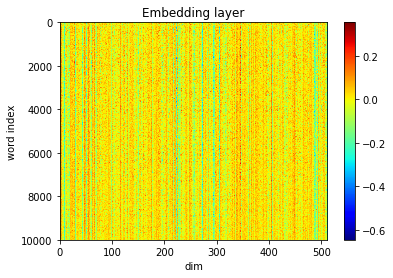

In [14]:
embed_wts = np.array(model.embedding.weight.data)
embed_norm = (embed_wts - embed_wts.mean()) / (embed_wts.max() - embed_wts.min())
plt.imshow(embed_norm, aspect = 'auto', cmap = 'jet')
plt.xlabel('dim'); plt.ylabel('word index');
plt.title('Embedding layer')
plt.colorbar()
embed_wts.shape

In [15]:
attn = model.attn

(256, 768)

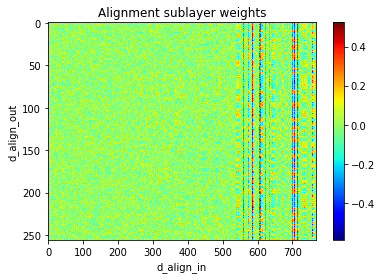

In [16]:
align_wts = np.array(attn.alignment.weight.data)
plt.imshow(align_wts, aspect = 'auto', cmap = 'jet')
plt.xlabel('d_align_in'); plt.ylabel('d_align_out')
plt.title('Alignment sublayer weights')
plt.colorbar()
align_wts.shape

(256, 768)

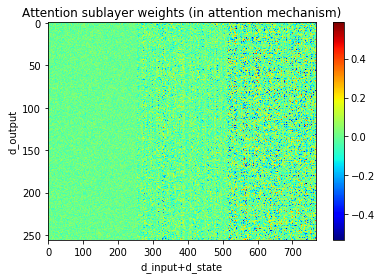

In [17]:
attn_wts = np.array(attn.attention.weight.data)
attn_norm = (attn_wts - attn_wts.mean()) / (attn_wts.max() - attn_wts.min())
plt.imshow(attn_wts, aspect = 'auto', cmap = 'jet')
plt.xlabel('d_input+d_state'); plt.ylabel('d_output')
plt.title('Attention sublayer weights (in attention mechanism)')
plt.colorbar()
attn_wts.shape

Sequence attention visualization by mapping the alignment weights (in the attention mechanism) at each step of the input:

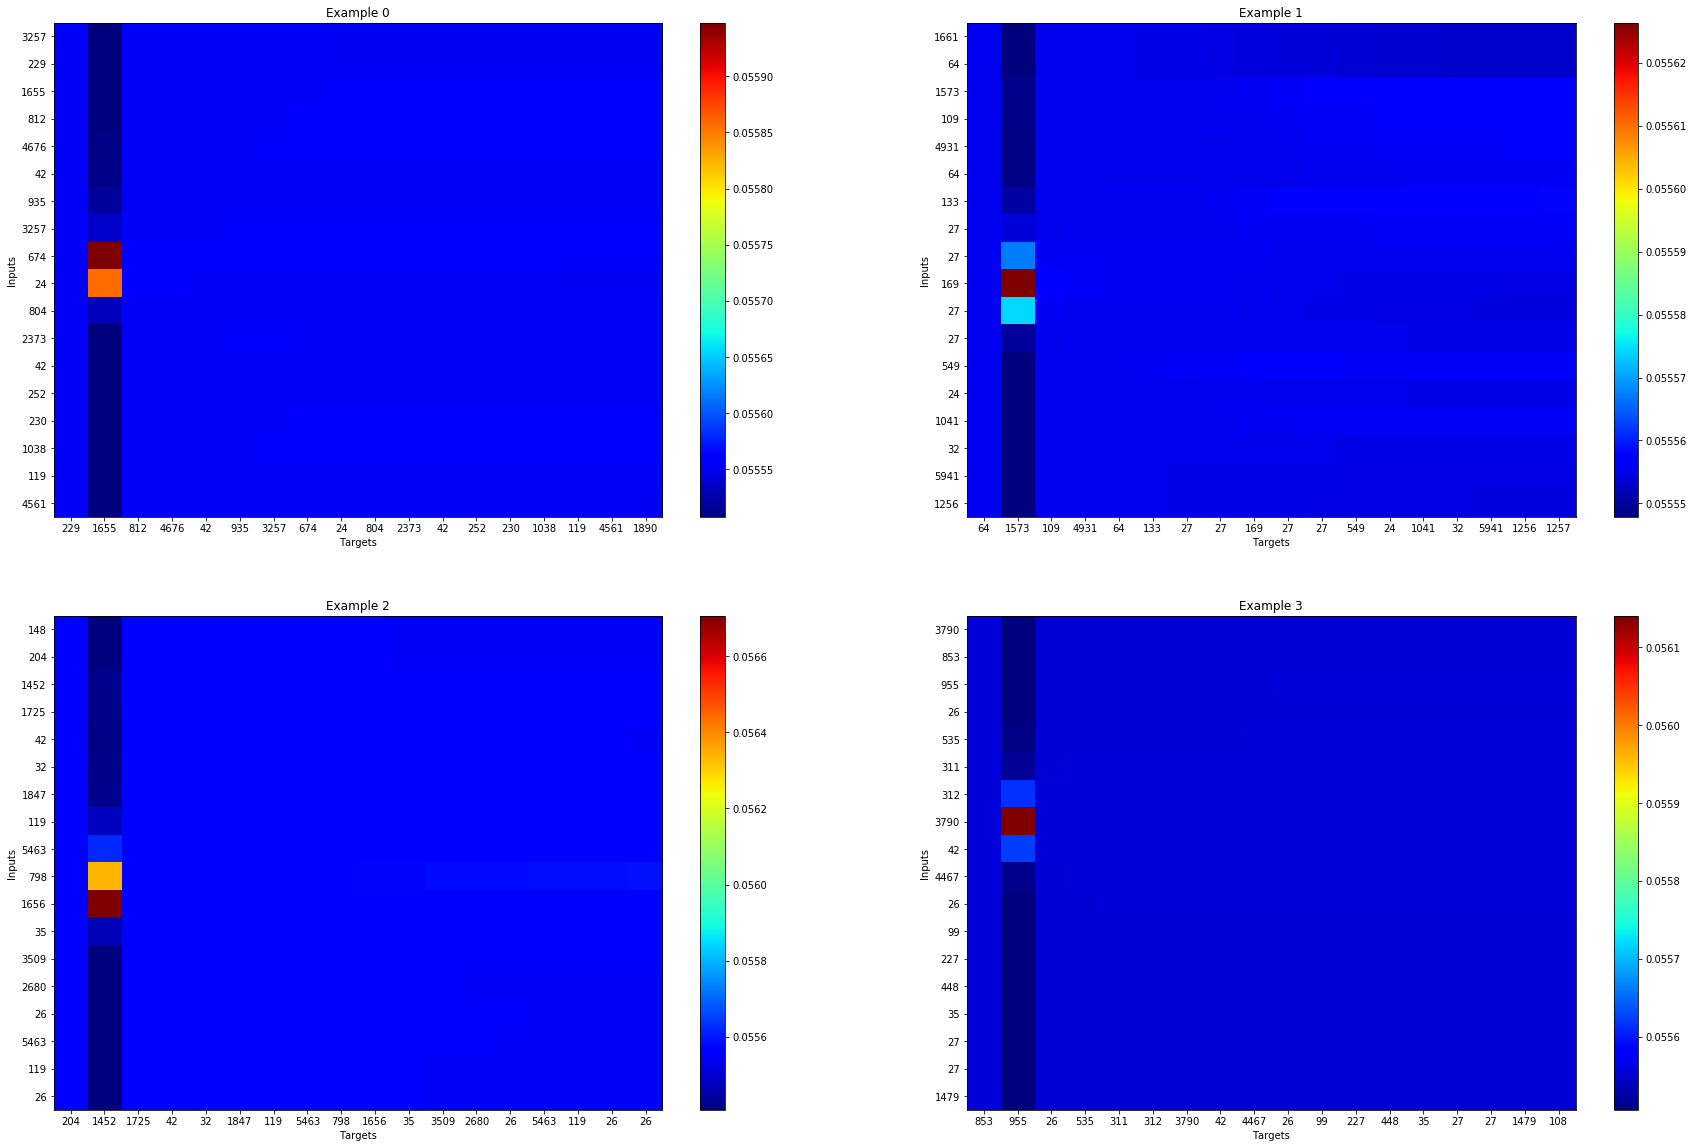

In [18]:
cols = 2
rows = nb//cols
fig, axs = plt.subplots(rows, cols, figsize = (30, 20))
for b in range(nb):
    wts = attn.attn_wts[:,b,:]
    wts_mean = wts.mean()
    wts_max = wts.max()
    wts_min = wts.min()
    norm = (wts - wts_mean) / (wts_max - wts_min)
    r = b // cols
    c = b % cols
    ax = axs[r, c]
    im = ax.imshow(wts, aspect = 'auto', cmap = 'jet')
    # Fix labels
    xlabels = list(targets[b].data)
    ax.set_xticks(range(seq_len))
    ax.set_xticklabels(xlabels)
    ax.set_xlabel('Targets')
    ylabels = list(data[:,b].data)
    ax.set_yticks(range(seq_len))
    ax.set_yticklabels(ylabels)
    ax.set_ylabel('Inputs')
    ax.set_title('Example %d' % b)
    fig.colorbar(im, ax = ax)
plt.show()

## Plot training stat curves

In [19]:
epoch_range = range(1, train_stats['epochs']+1)
train_stats.keys()

dict_keys(['epochs', 'train_loss', 'val_loss', 'grad_norm', 'grad_inf_norm', 'max_param', 'best_losses'])

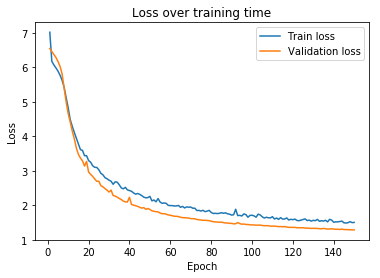

In [20]:
plt.plot(epoch_range, train_stats['train_loss'])
plt.plot(epoch_range, train_stats['val_loss'])
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss over training time')
plt.legend(['Train loss', 'Validation loss'])

Text(0.5,1,'Largest parameter magnitude over training time')

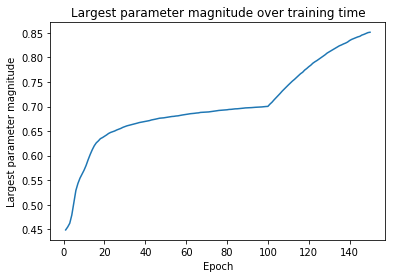

In [21]:
plt.plot(epoch_range, train_stats['max_param'])
plt.xlabel('Epoch'); plt.ylabel('Largest parameter magnitude')
plt.title('Largest parameter magnitude over training time')

In [ ]:
fig, pnorm_ax = plt.subplots()
pnorm_ax.plot(epoch_range, train_stats['grad_norm'], 'b')
pnorm_ax.set_xlabel('Epoch');
pnorm_ax.set_ylabel('2-norm', color = 'b')

infnorm_ax = pnorm_ax.twinx()
infnorm_ax.plot(epoch_range, train_stats['grad_inf_norm'], 'r')
infnorm_ax.set_ylabel('infinite norm', color = 'r')

plt.title('Gradient norms over training time')
#fig.tight_layout()